## Мета практичої роботи

В цій практичній роботі, вцілому, потрібно було отримати певні дані з датчиків телефона, після чого обробити їх за допомогою python.
Тому найкраще що я зміг придумати - це записати амлітуду звукової хвилі всіх шести нот на гітарі. Використовував Phyphox.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("1.csv")

## Структура даних

є 6 файлів для кожної гітарної струни. Кожен файл має таймер та поточне значення dB.

In [4]:
df

,Time (s),Sound pressure level (dB)
0,0.000000,-63.112794
1,0.286150,NaN
2,0.392024,-62.808009
3,0.499698,-65.502356
4,0.608549,-69.908565
...,...,...
2889,312.088869,-64.464947
2890,312.197407,-64.284056
2891,312.306154,-64.486019
2892,312.414947,-65.629440


In [5]:
df.describe()

,Time (s),Sound pressure level (dB)
count,2894.000000,2886.000000
mean,156.323267,-47.182144
std,90.218260,10.978782
min,0.000000,-77.828566
25%,78.222141,-56.265397
50%,156.320242,-47.833019
75%,234.382920,-37.167796
max,312.521854,-24.318534


## Вигляд файлу звукозапису

Графік виглядає так. Щоб він так виглядав я бринькав кожну струну 30 раз з інтервалом в 10 секунд, да я по 5 хвилин бринькав кожну струну. Інтервал 10 секунд потрібен, тому що саме коли звук струни втихає, графік струни починає відрізнятися від інших і його можна дослідити, зкормити певнй моделі та вподальшому розпізнавати ці графіки.

<Axes: >

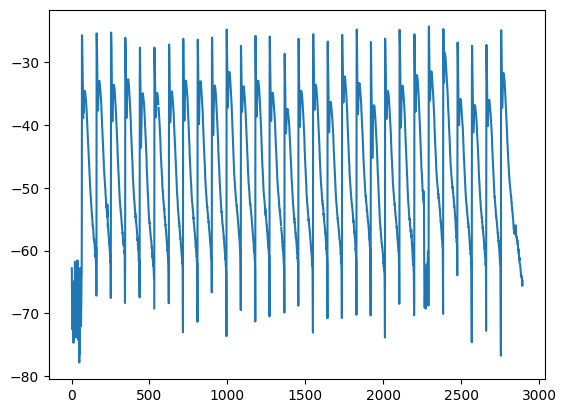

In [6]:
df["Sound pressure level (dB)"].plot()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894 entries, 0 to 2893
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time (s)                   2894 non-null   float64
 1   Sound pressure level (dB)  2886 non-null   float64
dtypes: float64(2)
memory usage: 45.3 KB


In [8]:
df["Sound pressure level (dB)"].size

2894

## Функція зчитування та нарізання на фрагменти графіку звукозаписа

Функція фасує нотні графіки так щоб на графіку було описуно звучання лише однієї ноти. Метод дуже простий, функція постійно дивиться трошки назад і коли помічає великий стрибок, відрізає фрагмент запису і заносить його в окрему зміну.

In [63]:
def create_wave_list(filename) :
    segments = []  
    temp = []
    df = pd.read_csv(filename)
    for i in range(10,df["Sound pressure level (dB)"].size):
        temp.append(df["Sound pressure level (dB)"][i] + 100)
        
        if df["Sound pressure level (dB)"][i] - df["Sound pressure level (dB)"][i-3] > 22 :
            segments.append(np.array(temp))
            temp = [] 
    return segments

## Фільтрування невдалих фрагментів

Функція відкидає короткі графіки, в яких точно не зафіксовано звучання ноти, бо я ше раз наголошу, що бринькав струну кожні 10 секунд в повній тиші. Також обрізає кожен графік по розміру найменшого графіка, для того щоб всі графіки були одного розміру. Також виводить розміри всіх масивів

In [9]:
def filter_real_waves(waves) :
    waves = [array for array in waves if len(array) >= 60]
    
    min_len = min(len(array) for array in waves)
    waves = [array[:min_len-1] for array in waves]
    
    for array in waves :
        print(len(array), end=" ")
    return waves

## Малювання графіків звучання нот

In [40]:
def draw_wave_list(wave_list) :
    plt.close("all")
    
    plots_per_pavge = 6
    cols = 3
    rows = plots_per_pavge // cols
    
    for i in range(0, len(wave_list), plots_per_pavge):
        subset = wave_list[i:i + plots_per_pavge]
        fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 2.5))
        axes = axes.flatten()
    
        for j in range(len(subset)):
            axes[j].plot(subset[j], marker='o', markersize=2, linewidth=0.8)
            axes[j].set_title(f"Сегмент {i + j + 1}", fontsize=9)
            axes[j].tick_params(labelsize=8)
            axes[j].grid(True)
    
        plt.tight_layout()
        plt.show()

## Інтерполяція масиву

Для того щоб праивльно модель визначала ноти, бажано шоб всі масиви були одного і тогож розміру, тому інтерполяція - " в обчислювальній математиці спосіб знаходження проміжних значень величини за наявним дискретним набором відомих значень"  автор - "Wikipedia", це правильний інструмент для того щоб привести всі масиви в всіх наборах нот до одного розміру.

In [50]:
def interpolate_waves(wave_list, dot_number) : 
    
    max_len = max(len(array) for array in wave_list)

    if dot_number < max_len :
        raise Exception("Dude here a problem. The bigest graph in your list is bigger than dot_number. But interpolation isn`t work like that. This function must add dots not remove them. Man do something with that")

    new_wave_list = []
    for note in wave_list :
        note_x = np.linspace(0,1, len(note))
        new_x = np.linspace(0,1,dot_number)
        new_note = np.interp(new_x,note_x,note)
        new_wave_list.append(new_note)
    
    return new_wave_list

In [12]:
note_graph = []
note_code = []

In [13]:
segments = create_wave_list("1.csv")

In [14]:
segments = segments[1:]

In [15]:
segments = filter_real_waves(segments)

86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 

In [16]:
note_graph+=segments
note_code += [1]*len(segments)

## Графіки 1 ноти

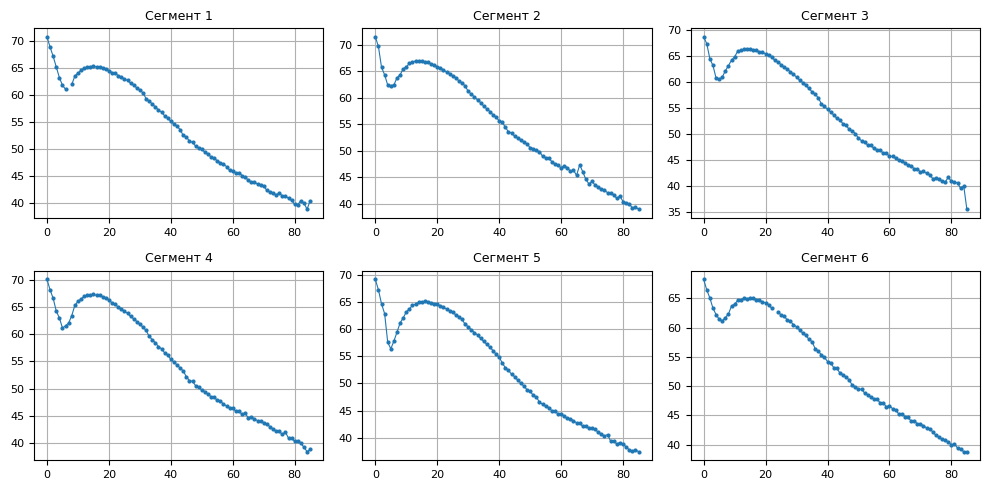

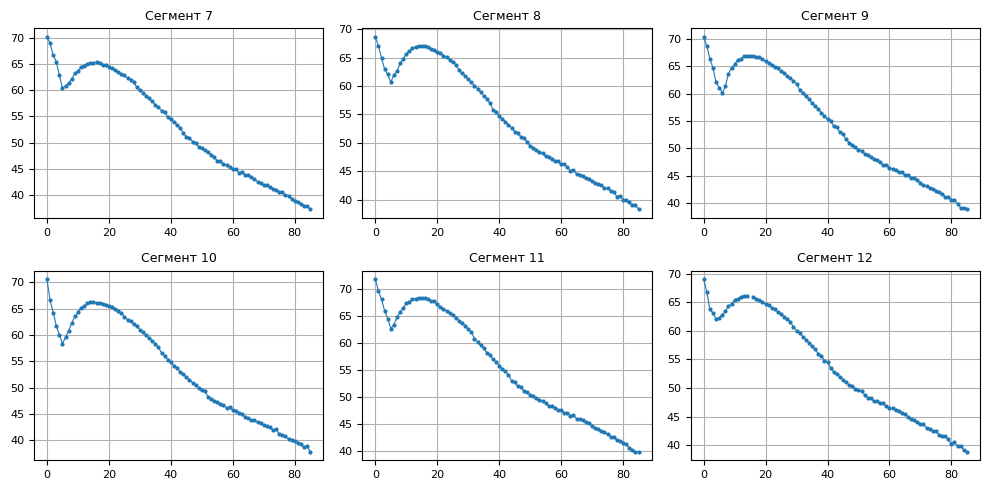

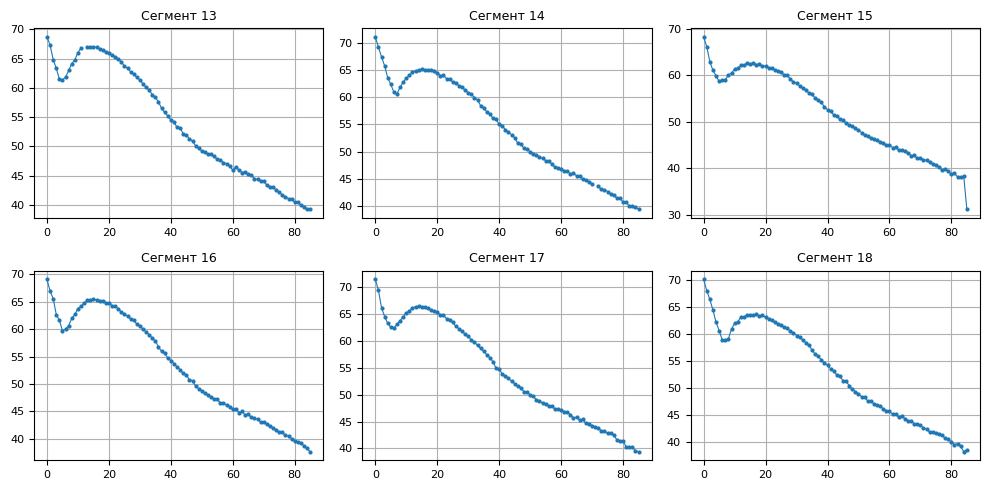

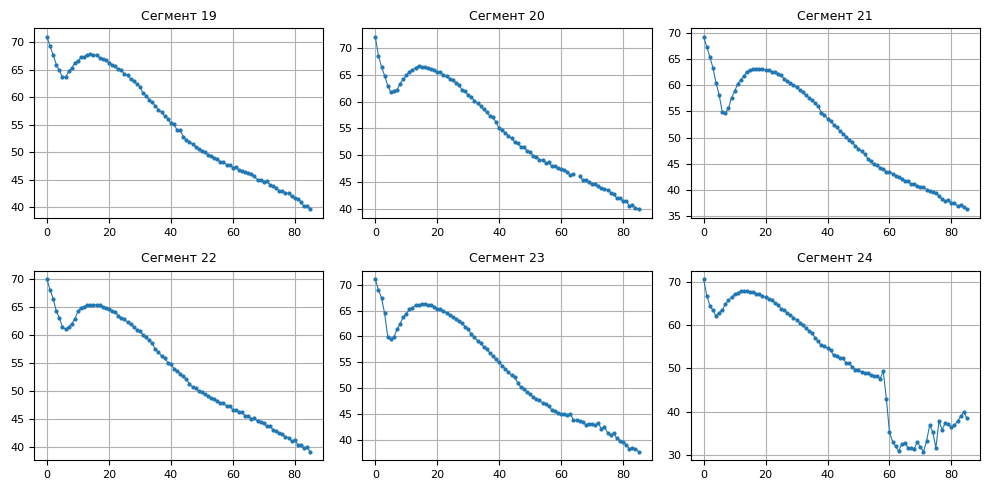

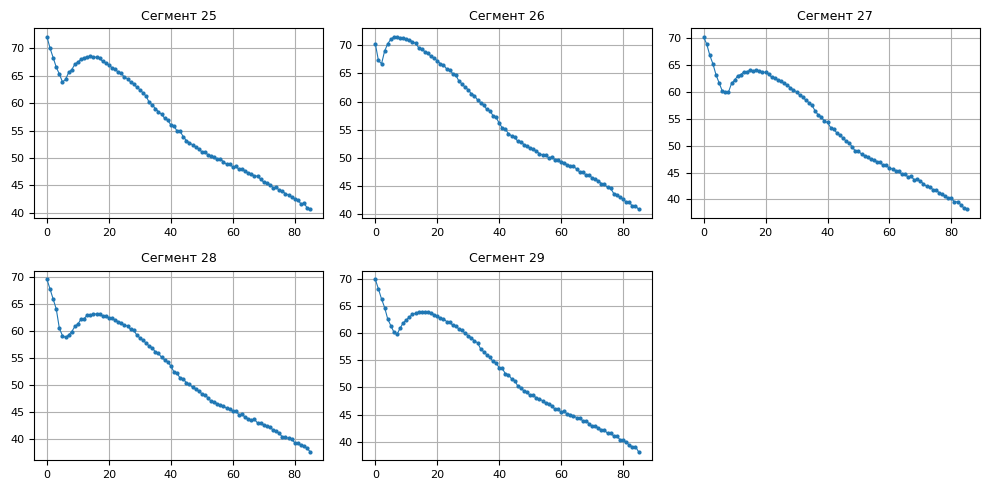

In [17]:
draw_wave_list(segments)

## Графіки 2 ноти

86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 

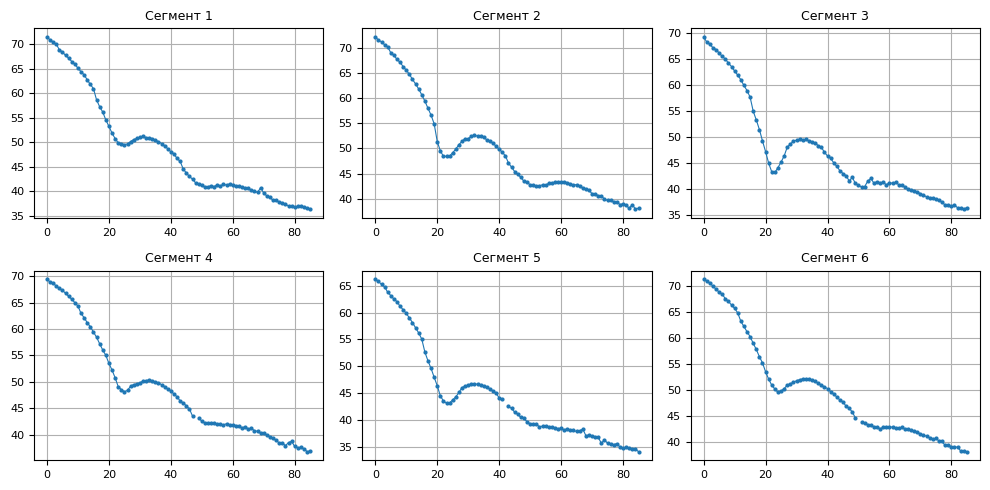

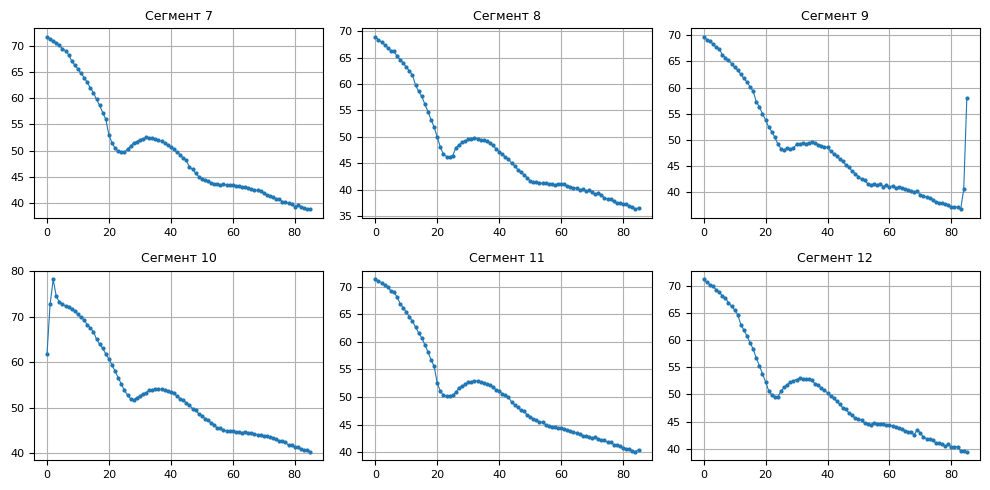

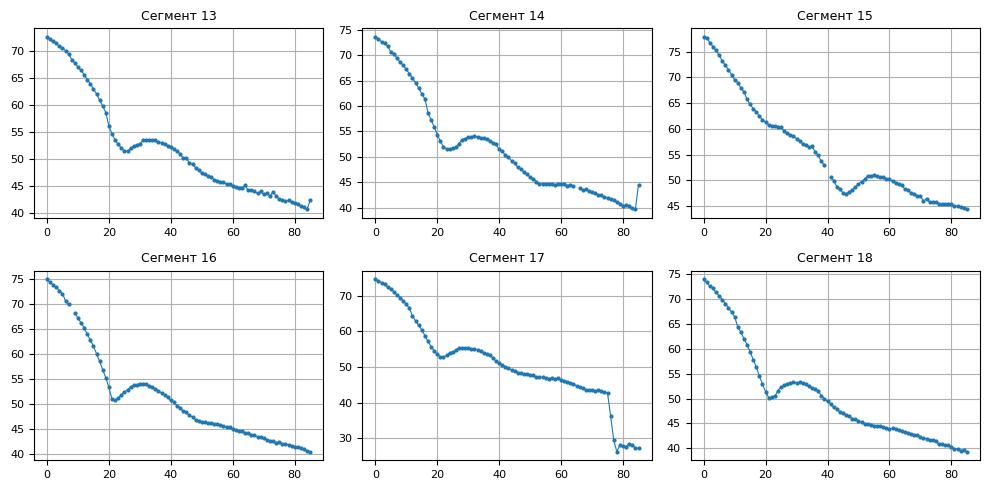

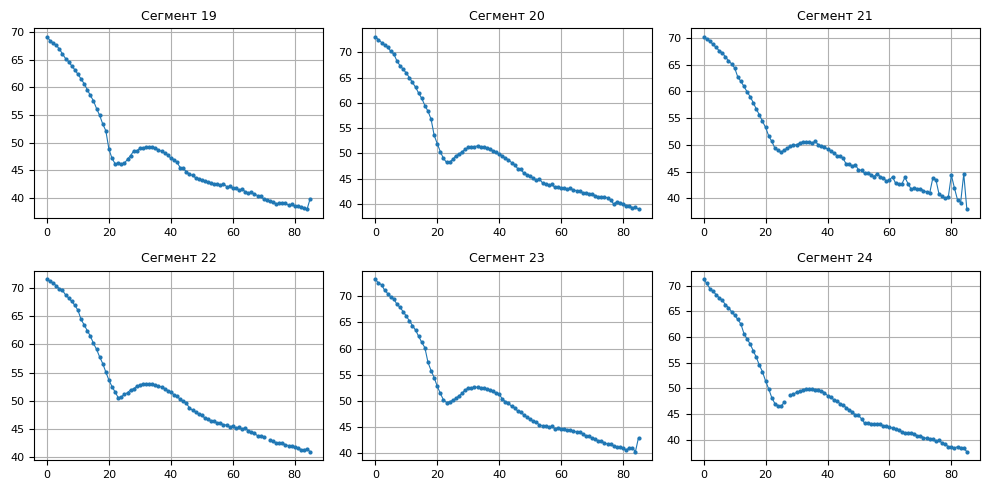

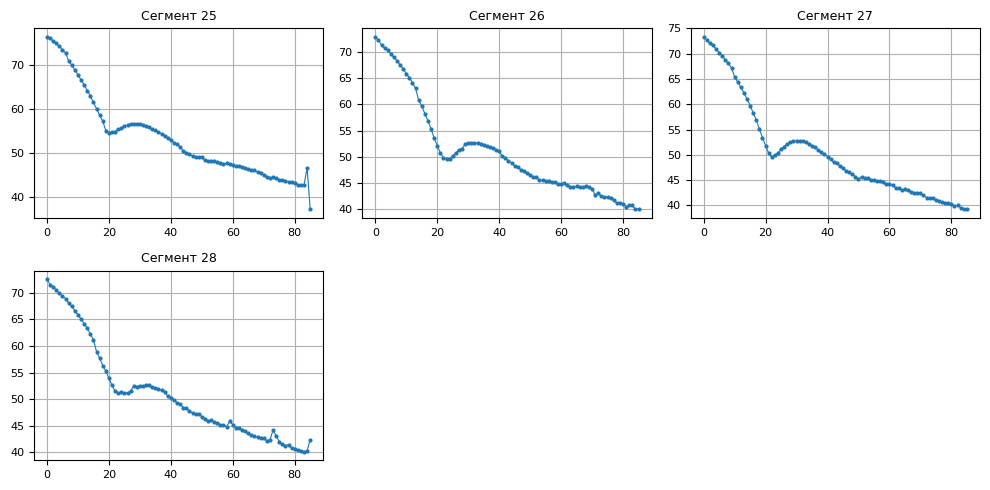

In [18]:
segments = create_wave_list("2.csv")
segments = segments[1:]
segments = filter_real_waves(segments)
draw_wave_list(segments)

In [19]:
note_graph+=segments
note_code += [2]*len(segments)

## Графіки 3 ноти

87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 

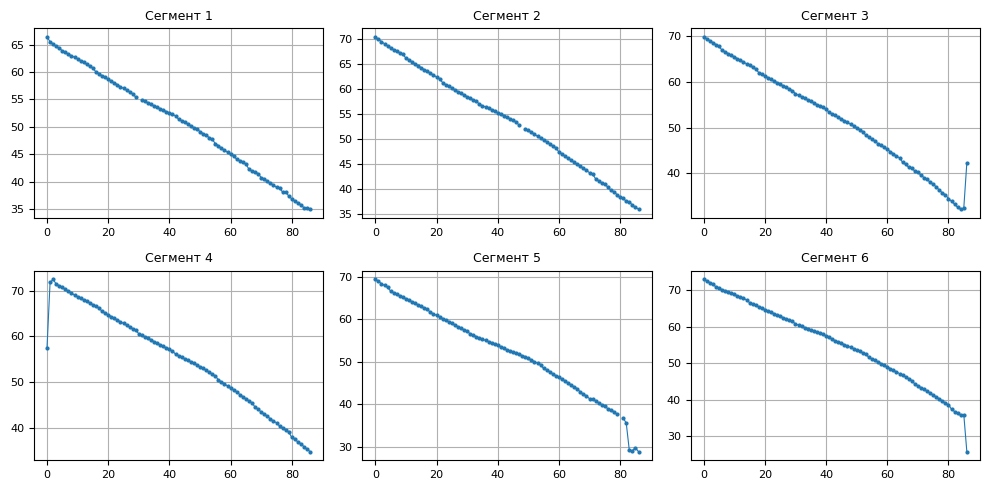

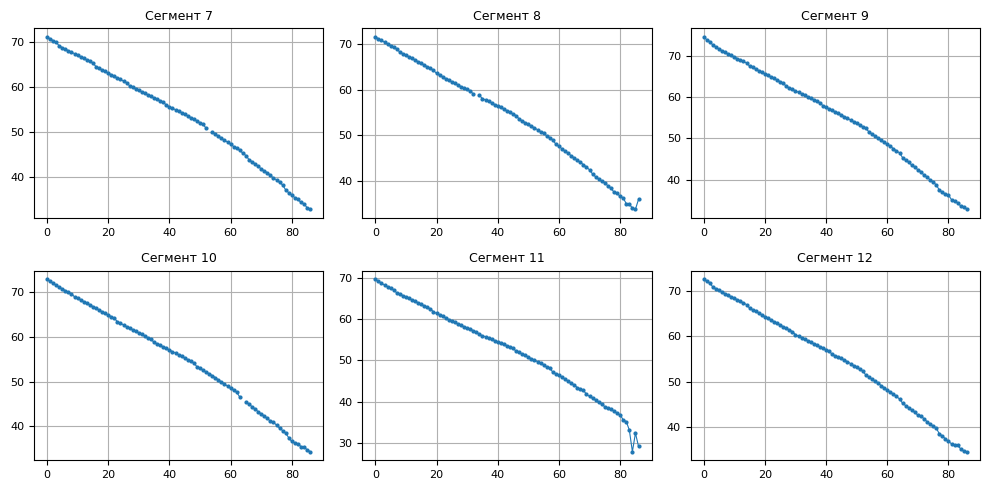

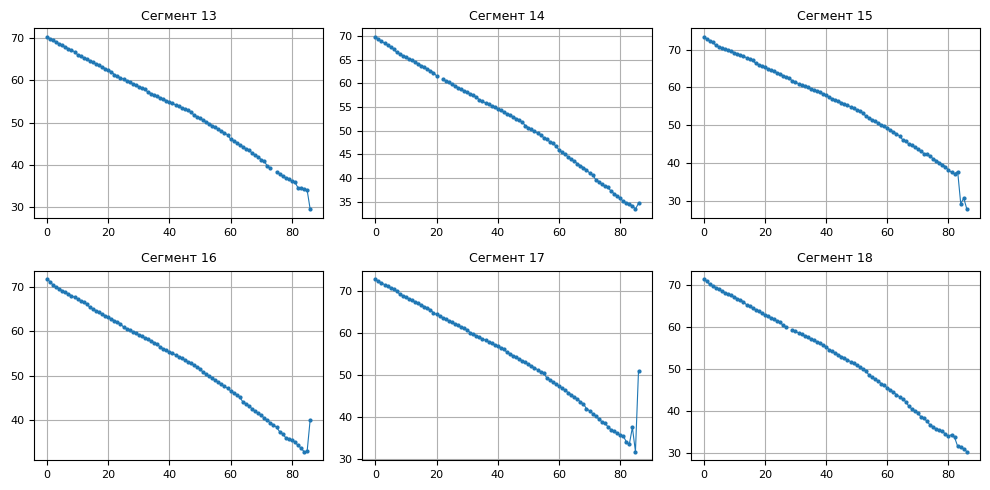

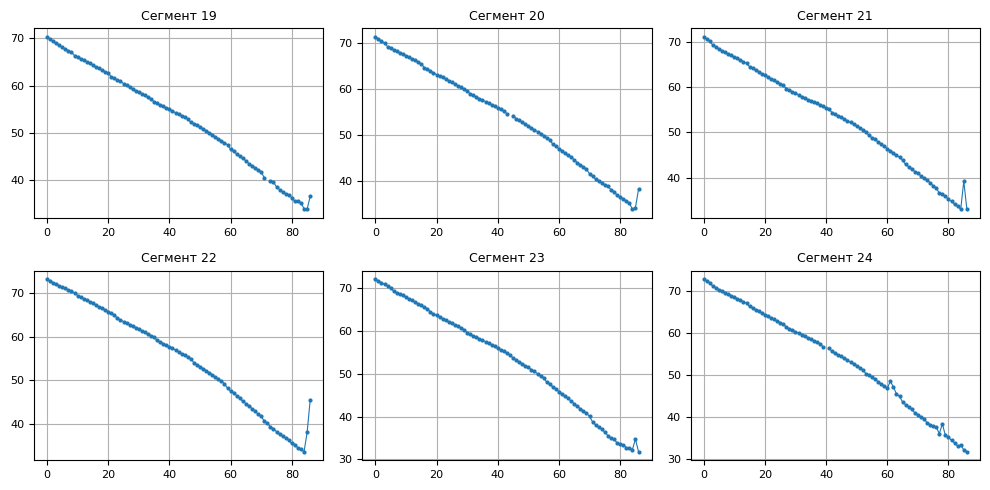

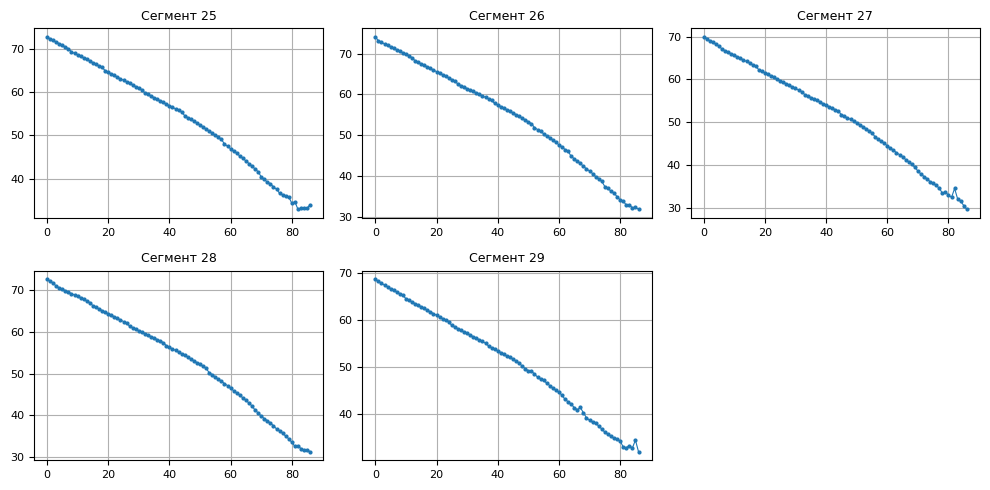

In [20]:
segments = create_wave_list("3.csv")
segments = segments[1:]
segments = filter_real_waves(segments)
draw_wave_list(segments)

In [21]:
note_graph+=segments
note_code += [3]*len(segments)

## Графіки 4 ноти

86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 

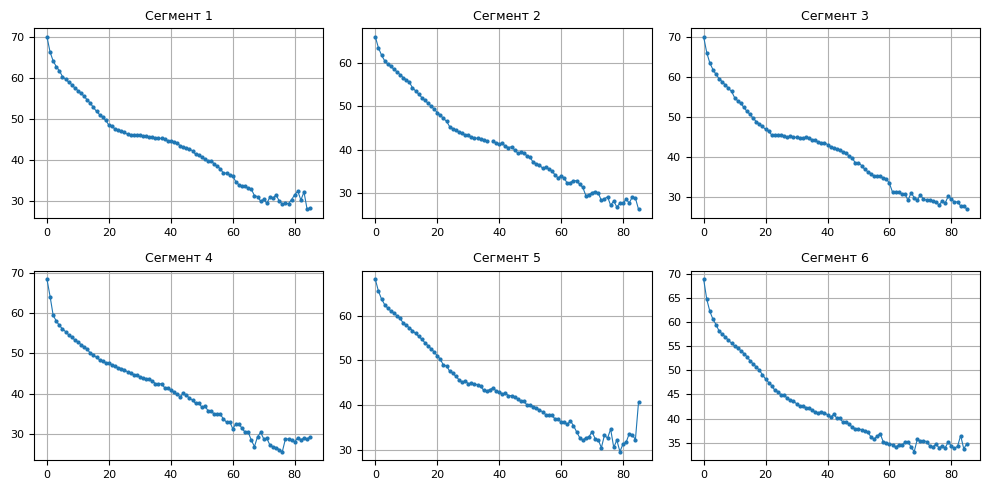

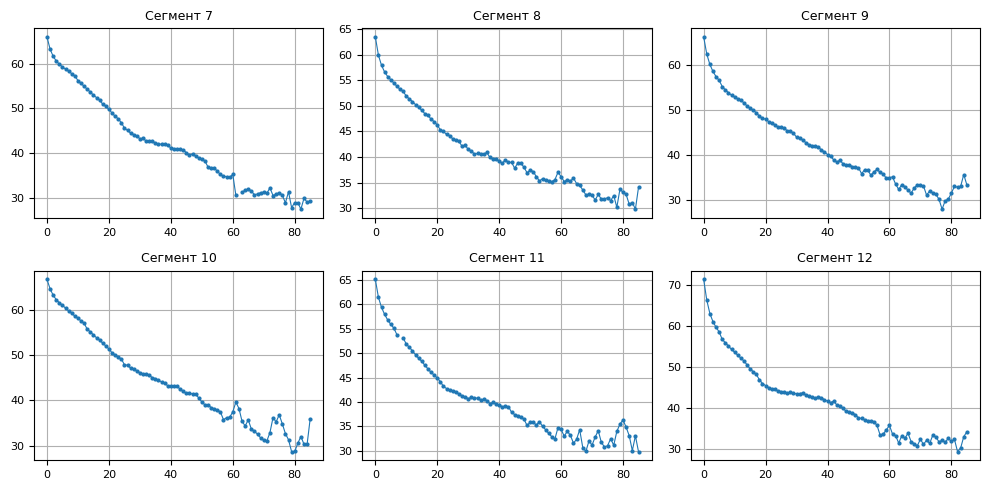

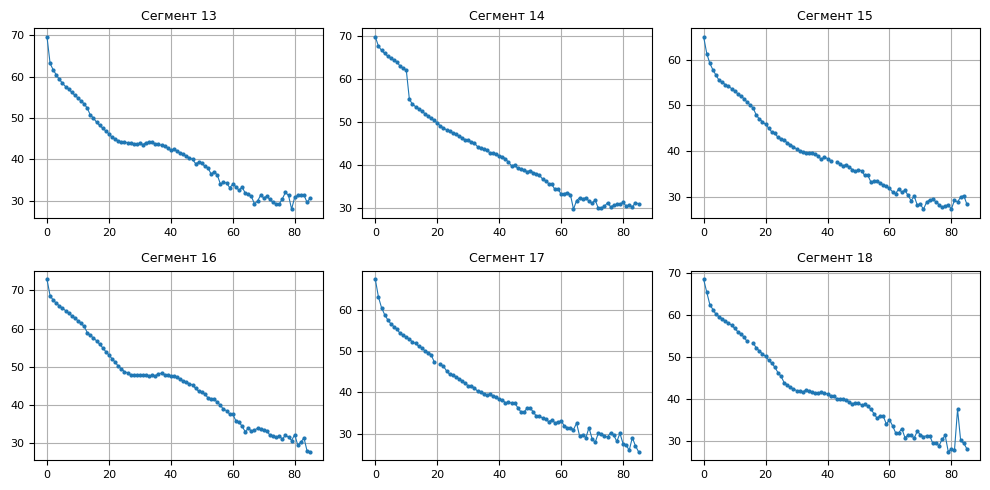

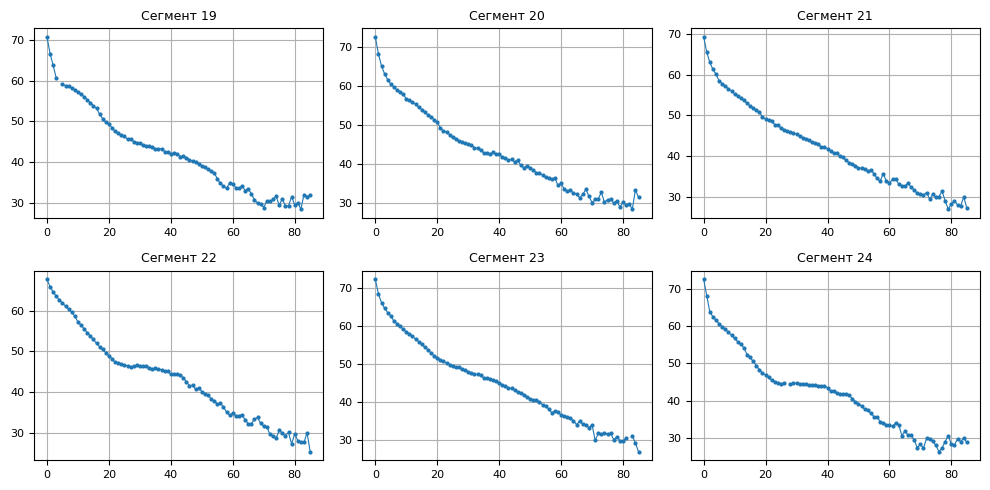

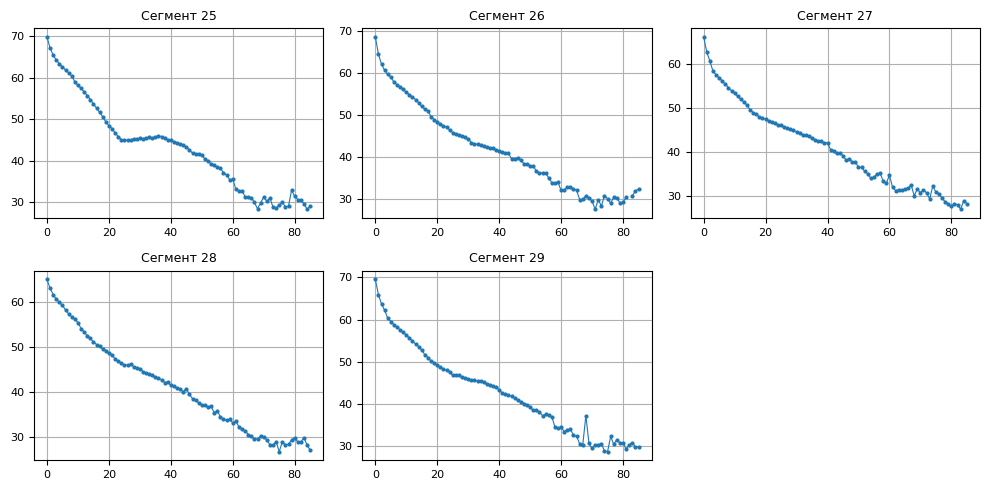

In [22]:
segments = create_wave_list("4.csv")
segments = segments[1:]
segments = filter_real_waves(segments)
draw_wave_list(segments)

In [ ]:
note_graph+=segments
note_code += [4]*len(segments)

## Графіки 5 ноти

64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 

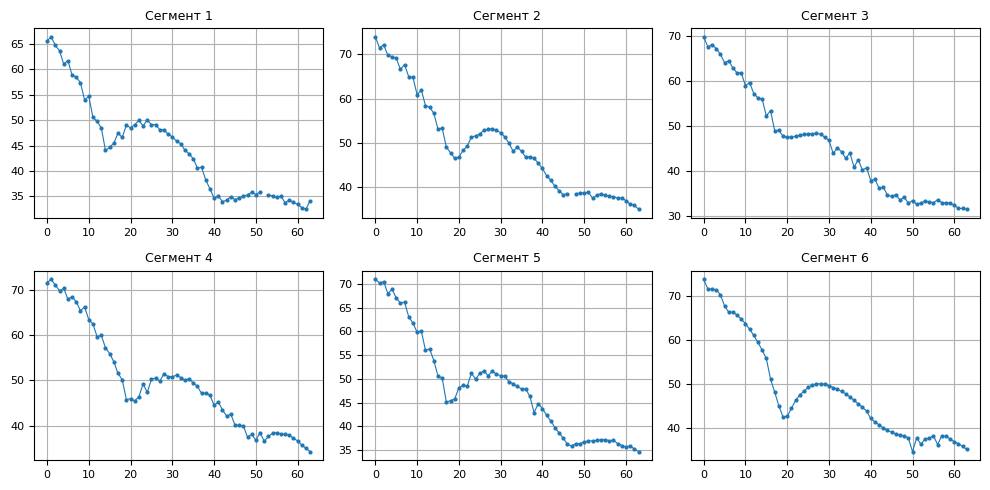

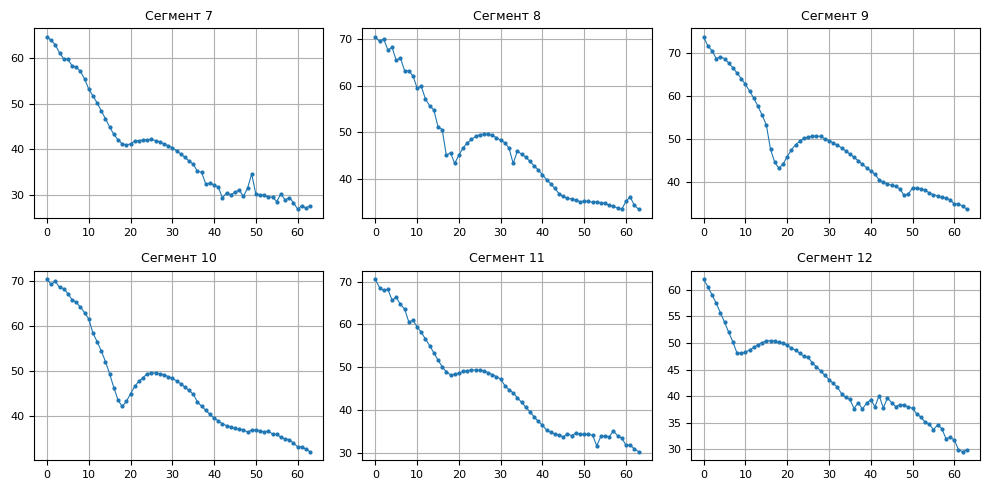

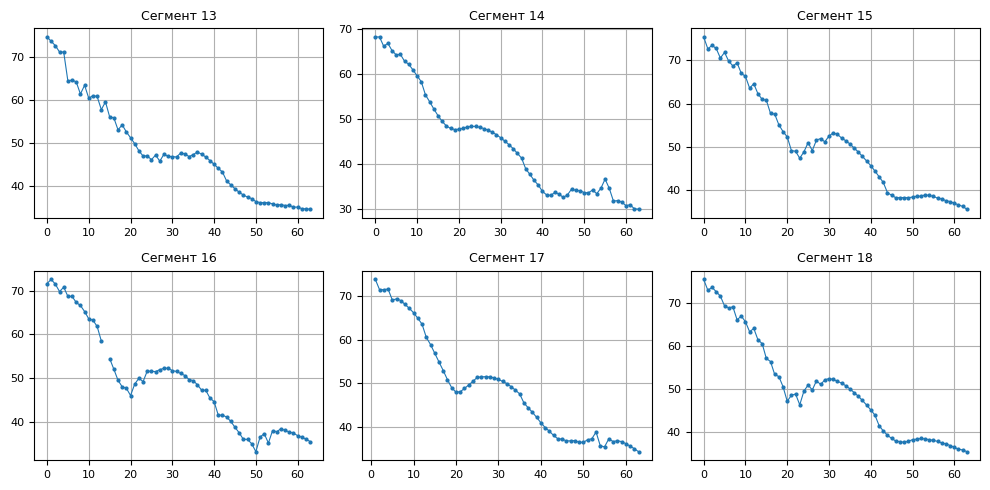

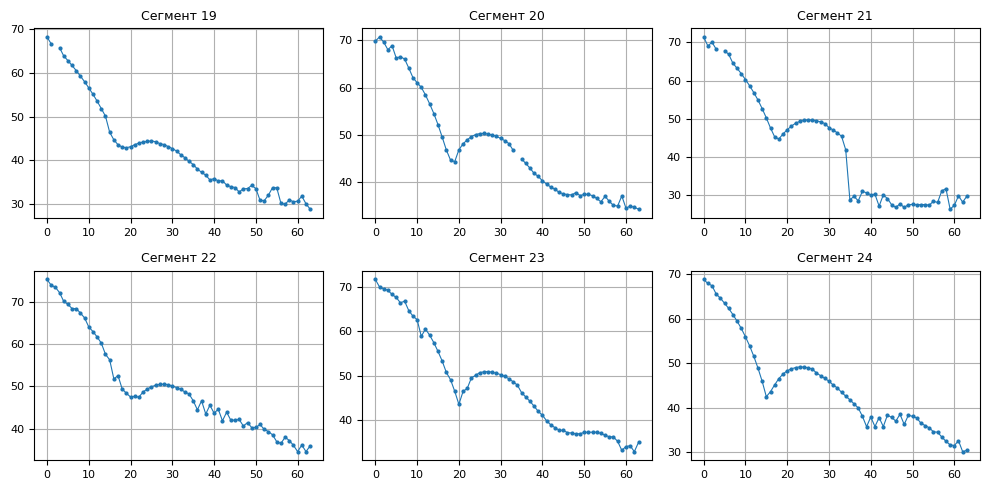

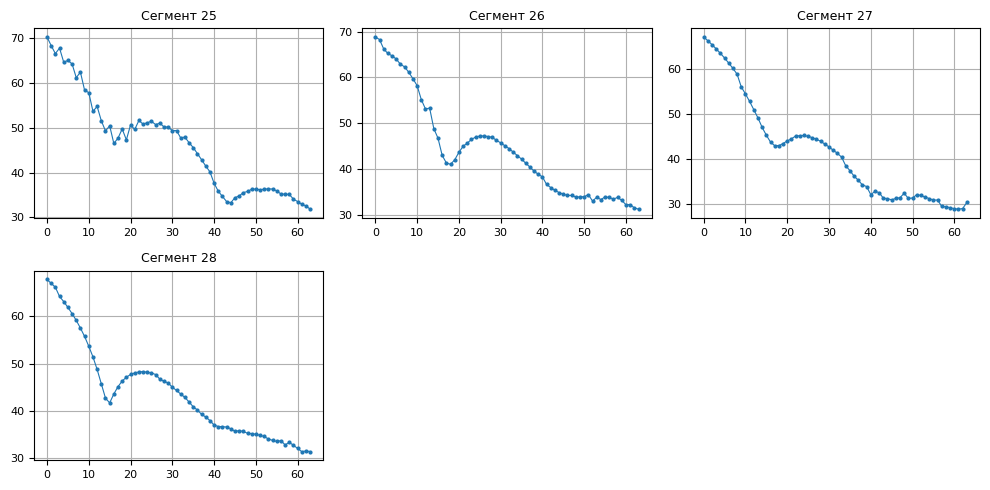

In [38]:
segments = create_wave_list("5.csv")
segments = filter_real_waves(segments)
segments = segments[1:]
draw_wave_list(segments)

In [25]:
note_graph+=segments
note_code += [5]*len(segments)

## Графіки 6 ноти

85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 

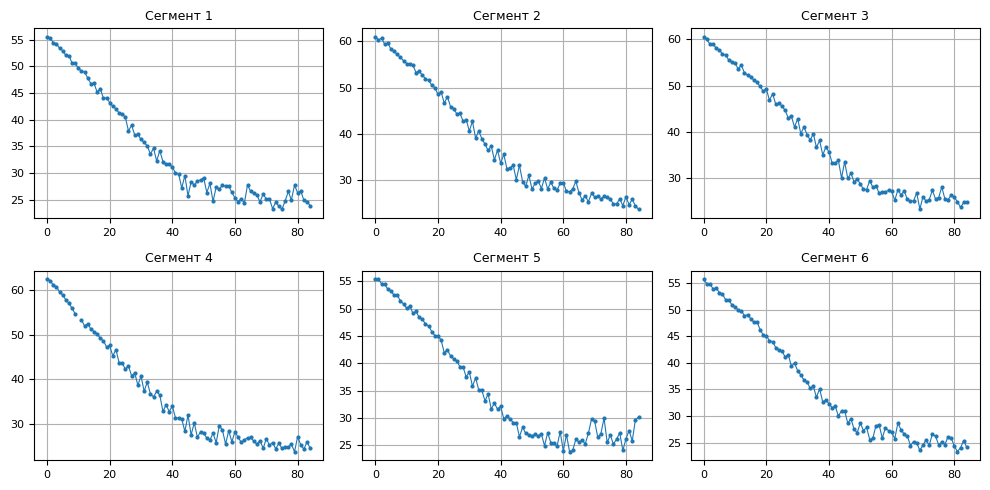

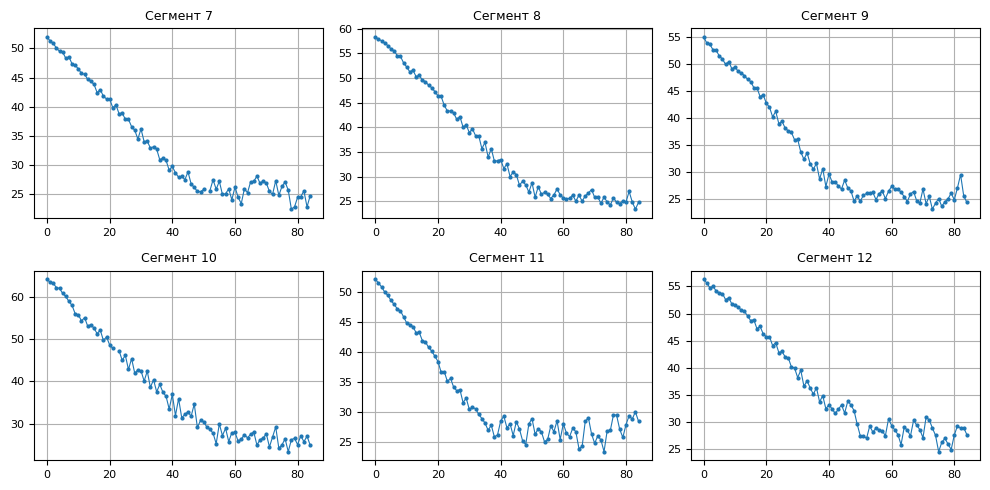

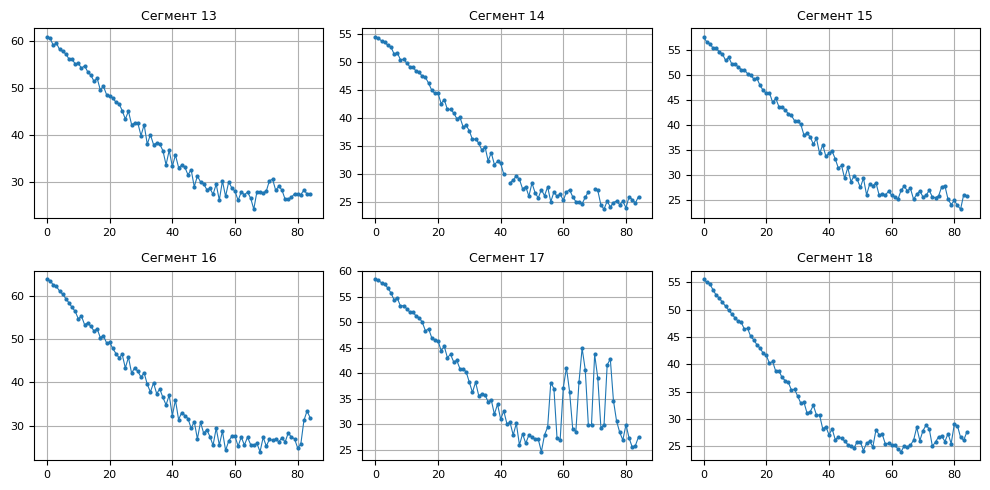

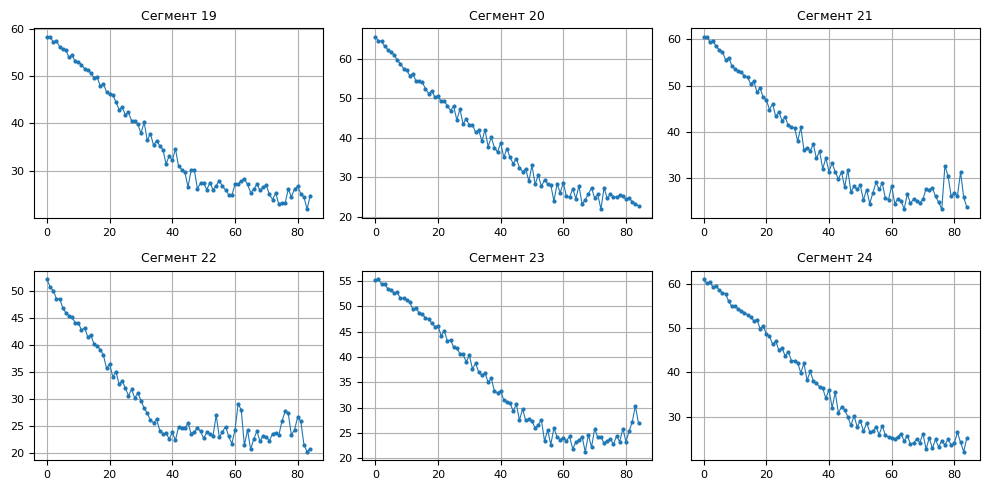

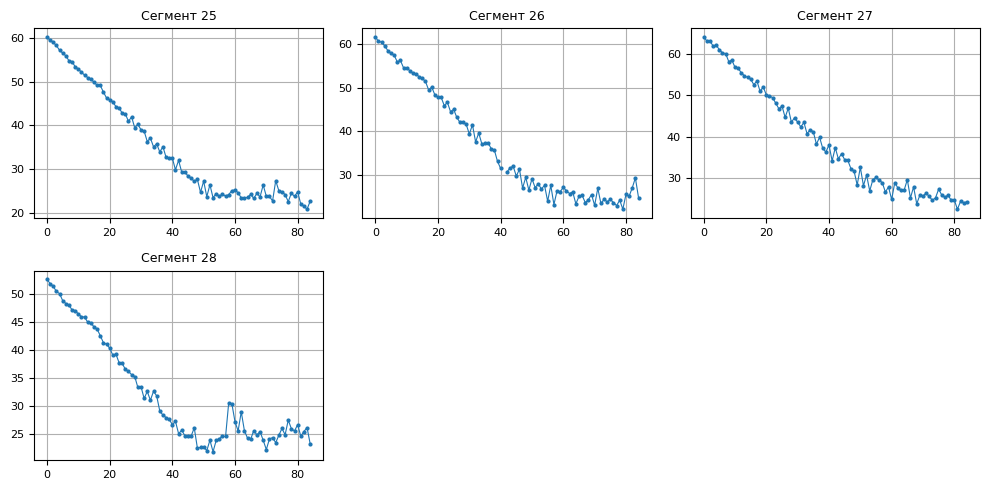

In [26]:
segments = create_wave_list("6.csv")
segments = filter_real_waves(segments)
segments = segments[2:]
draw_wave_list(segments)

In [27]:
note_graph+=segments
note_code += [6]*len(segments)

In [51]:
note_graph = interpolate_waves(note_graph,90)

## Графіки всіх нот після інтерполяції

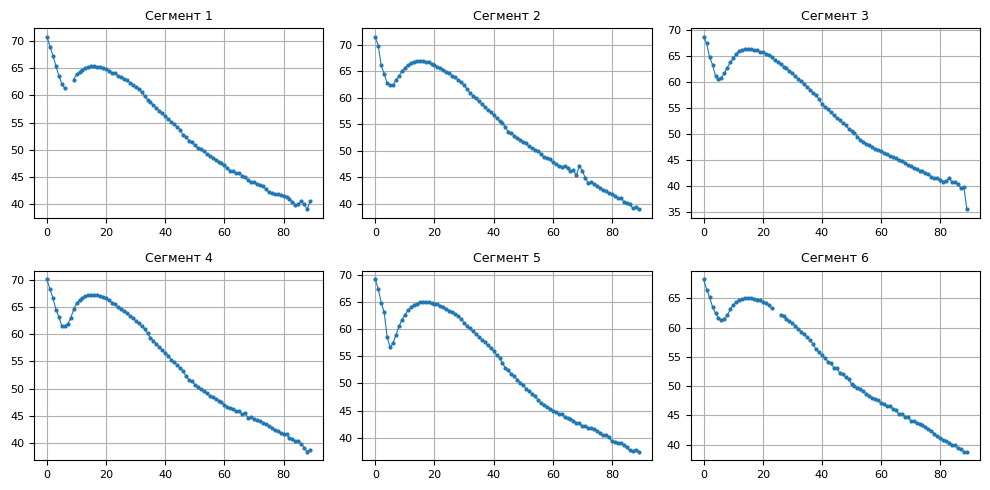

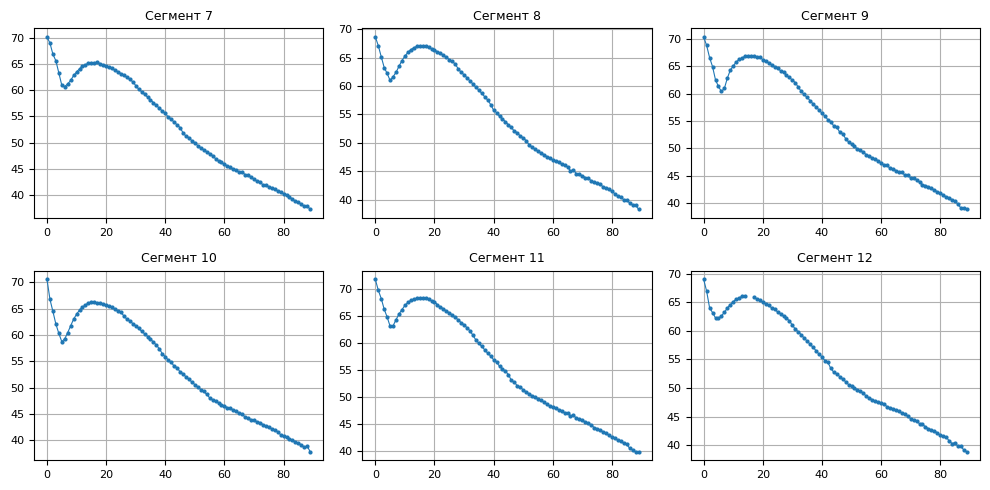

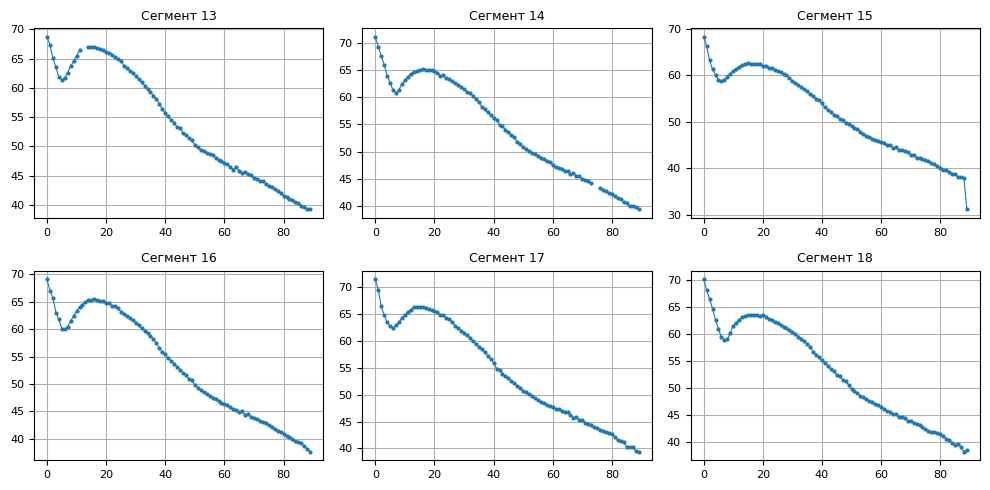

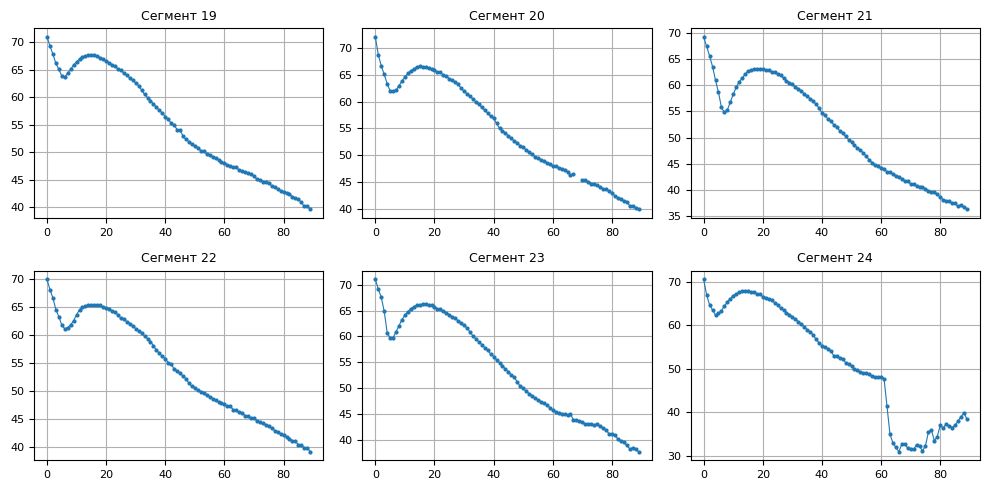

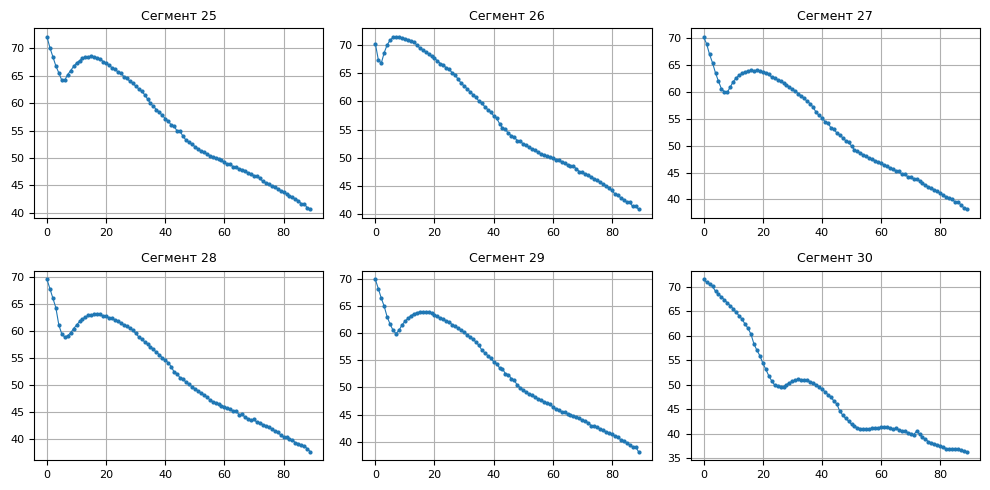

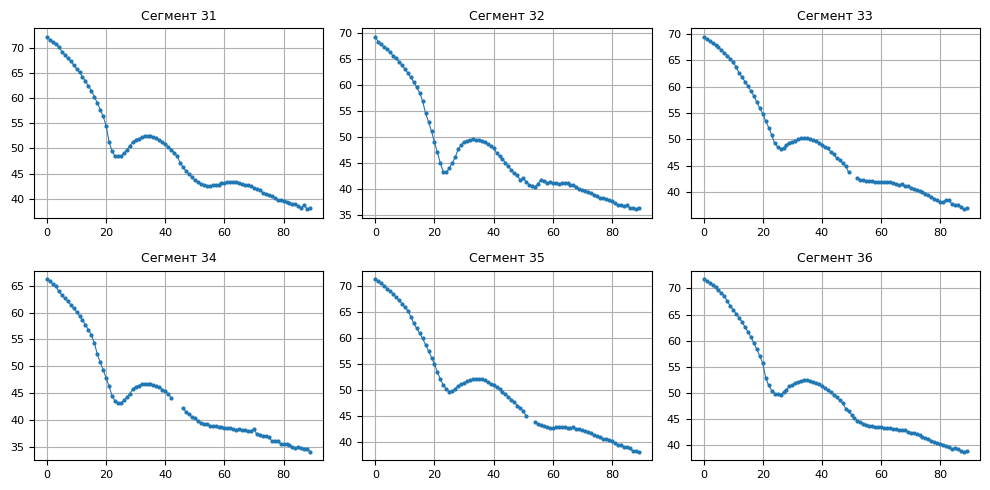

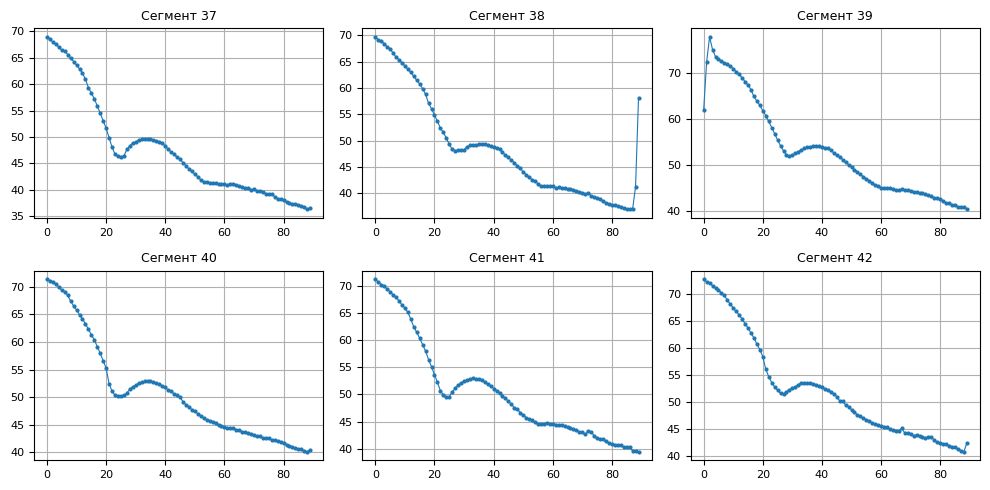

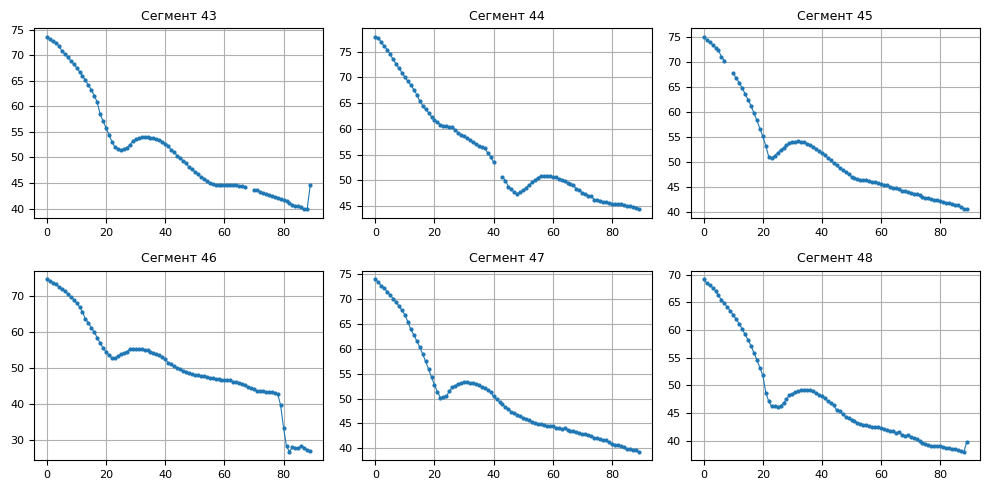

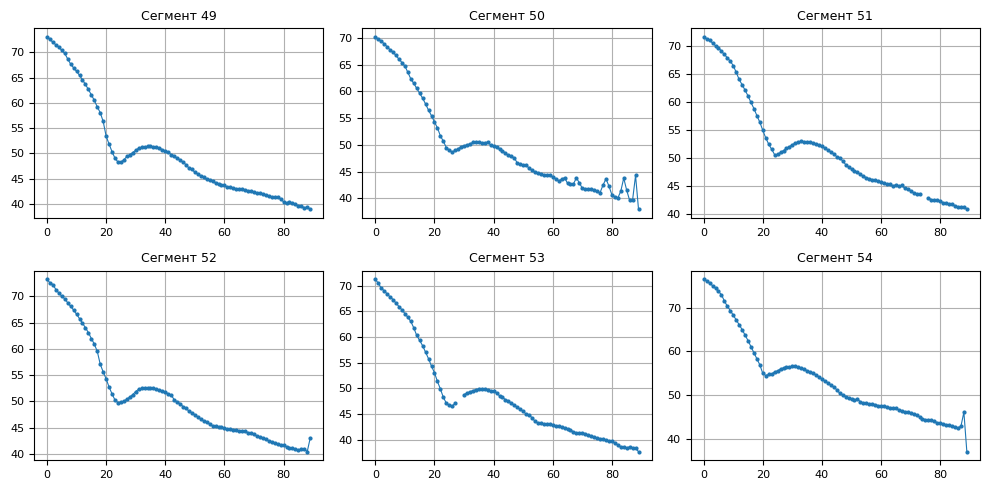

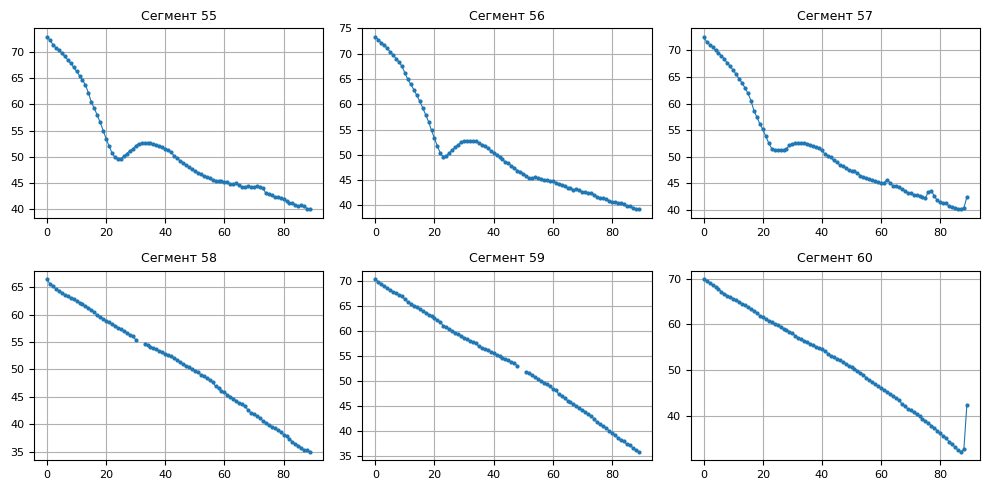

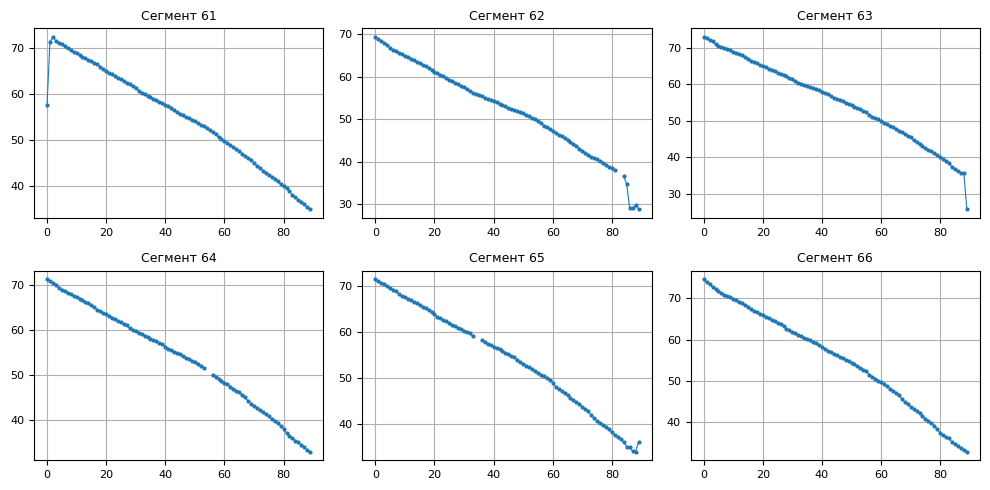

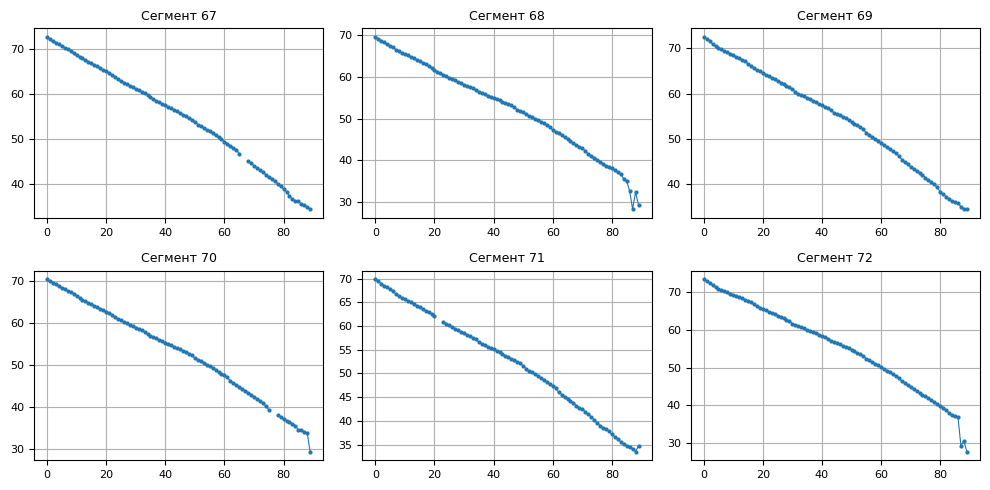

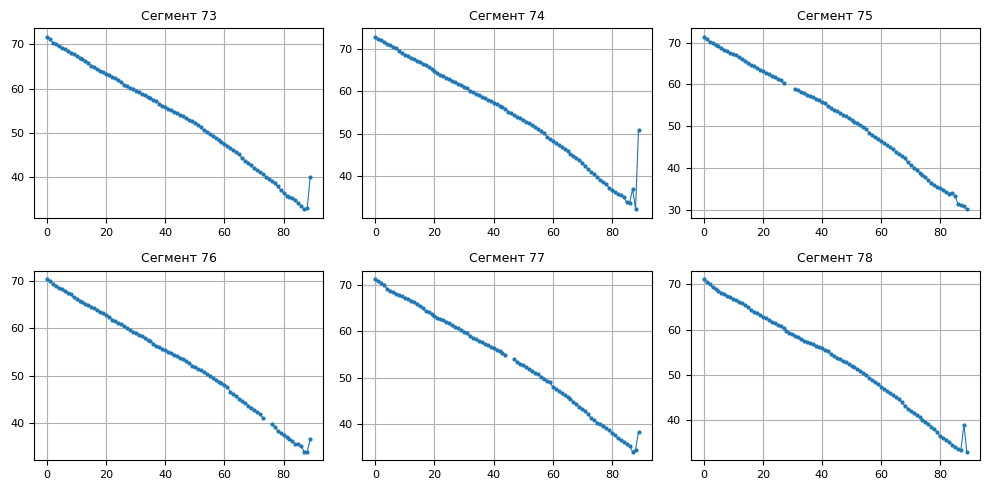

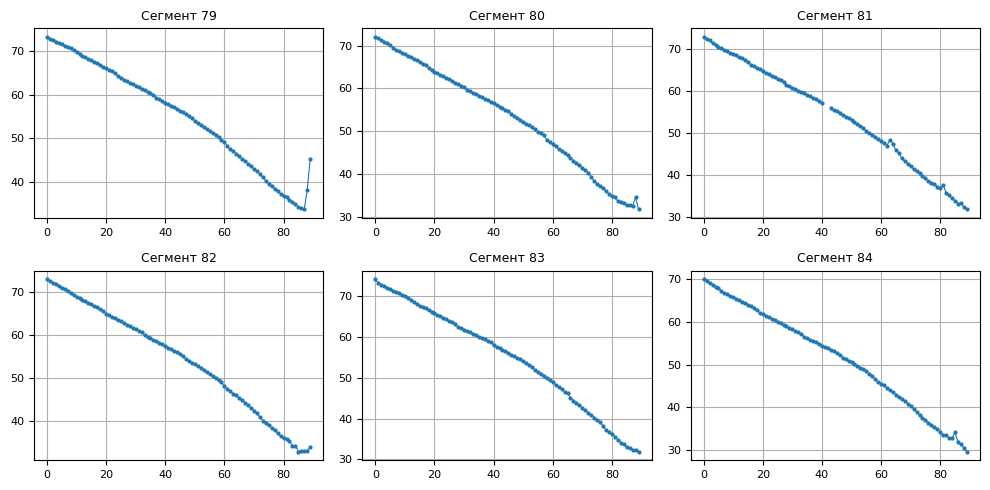

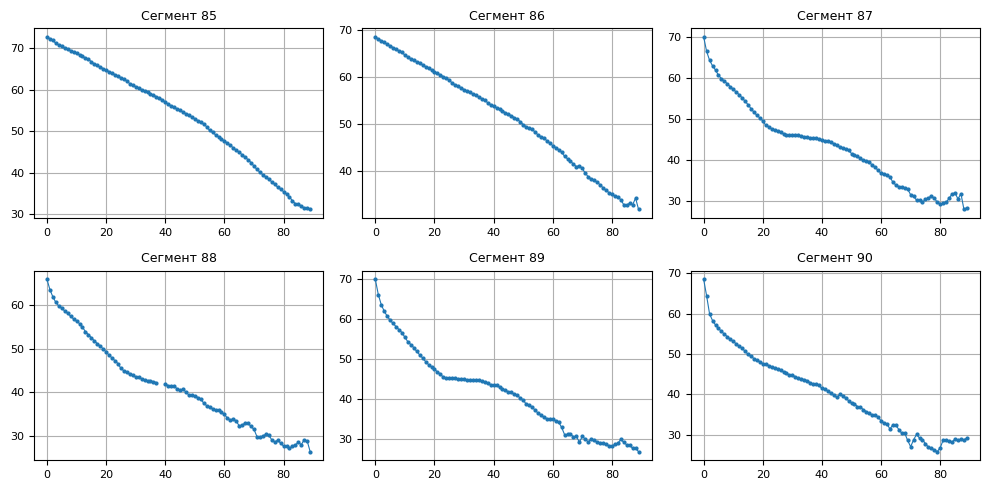

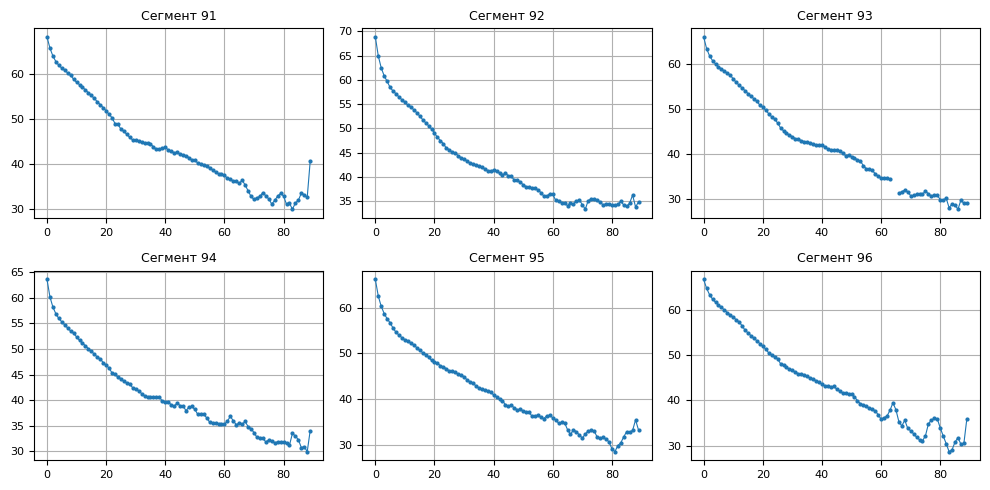

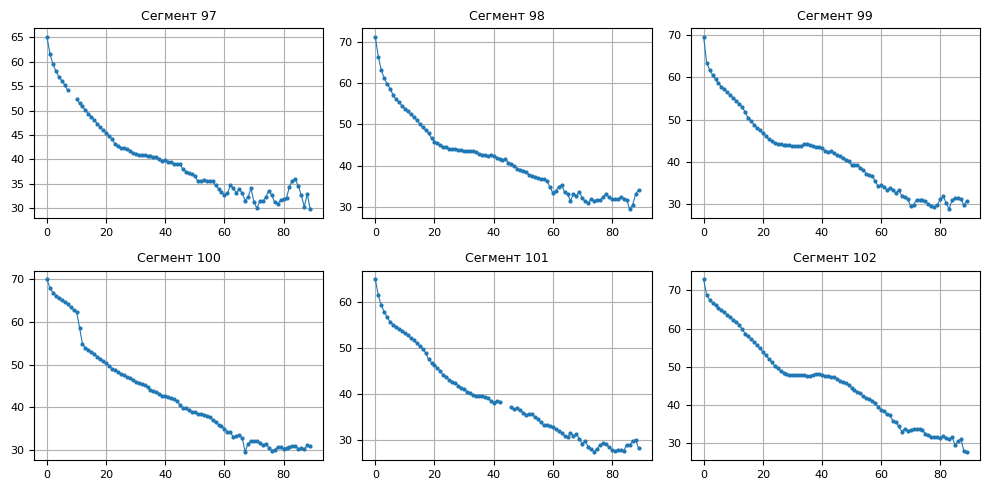

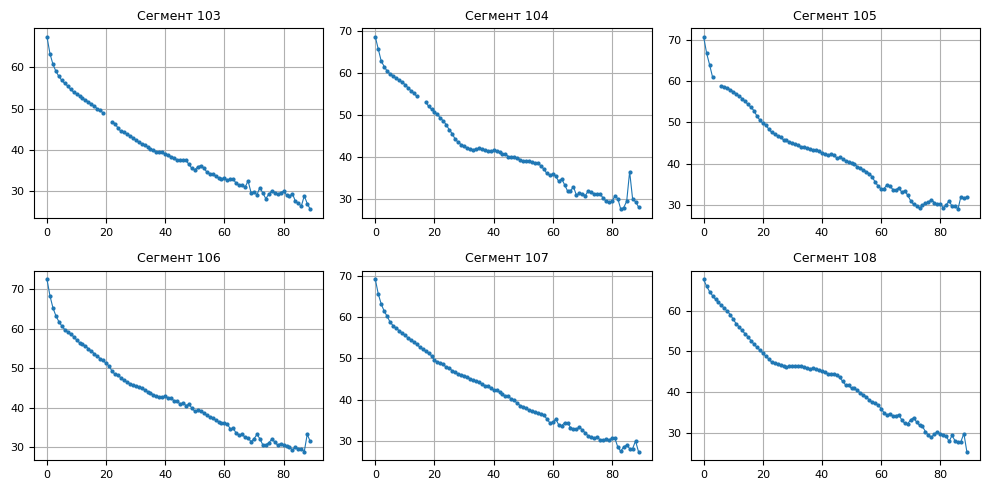

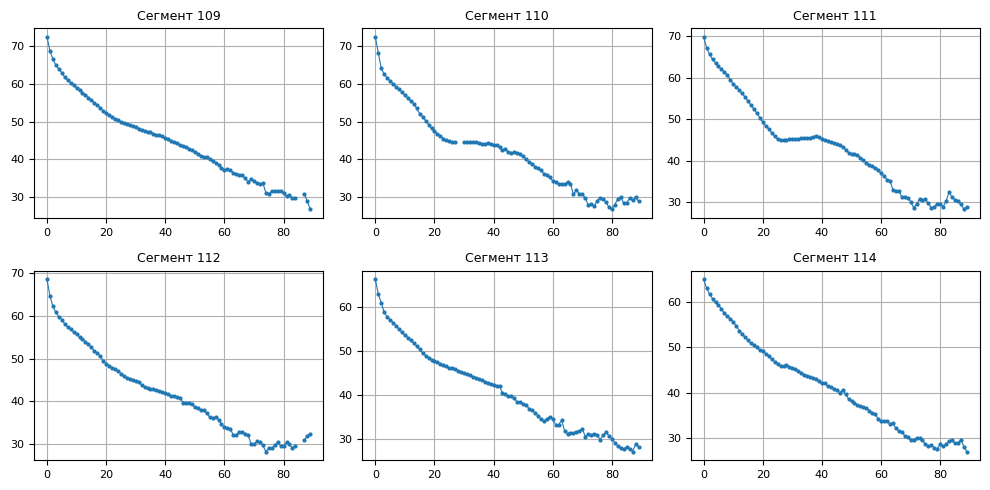

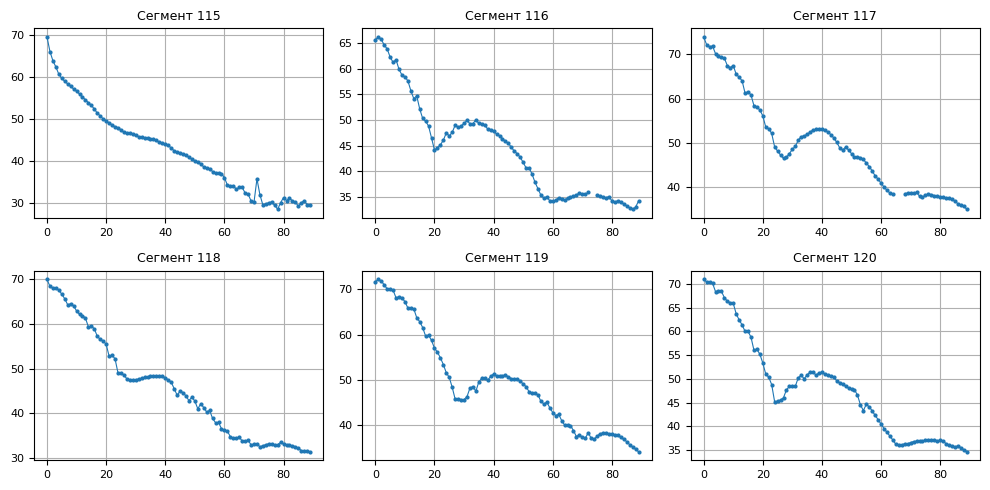

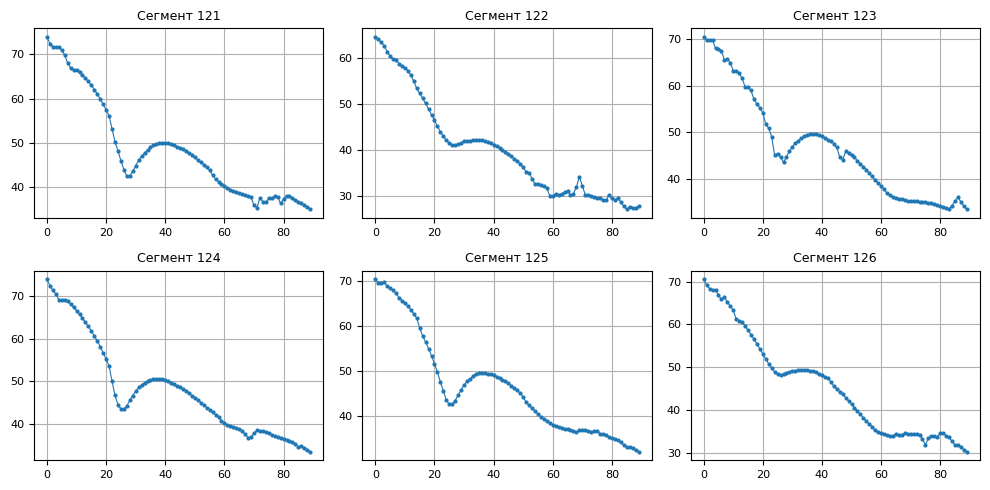

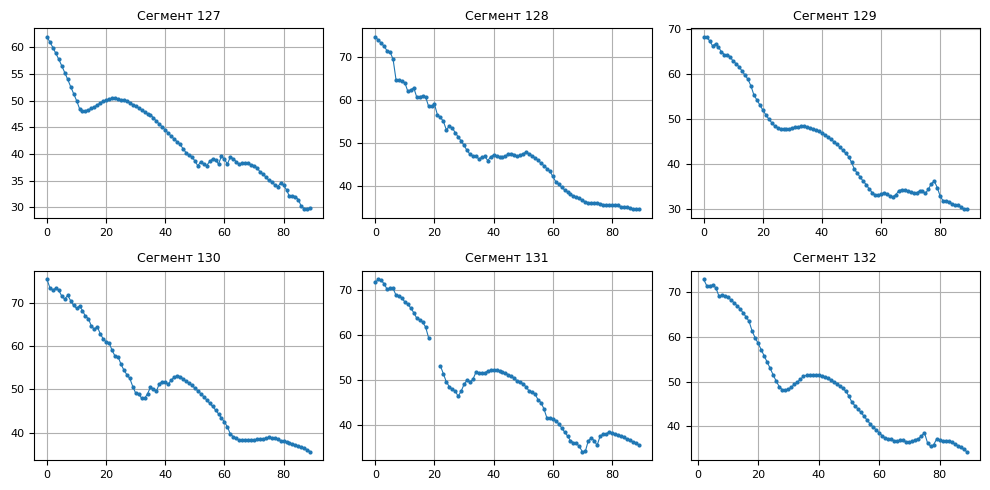

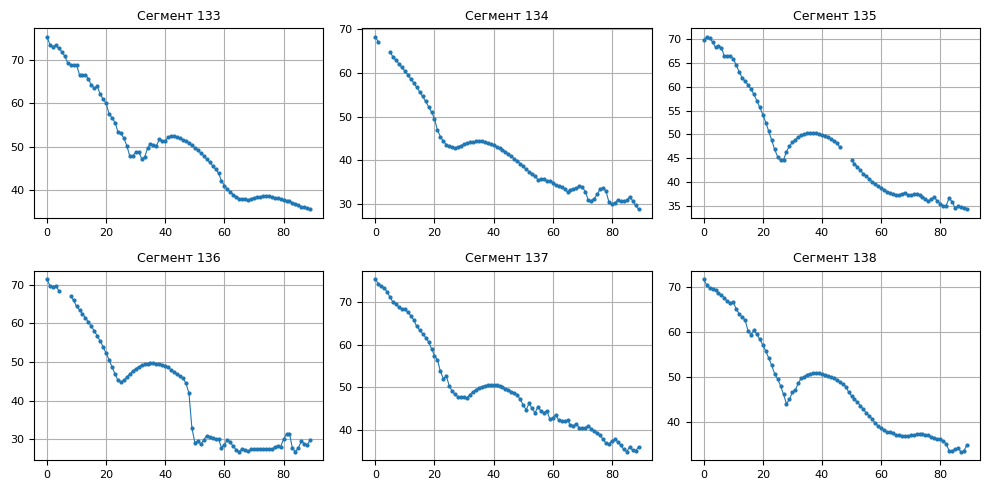

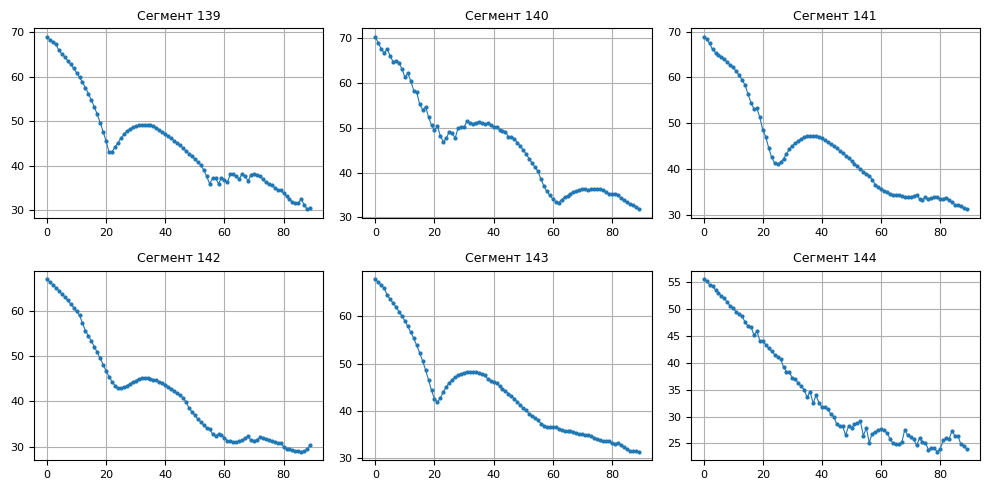

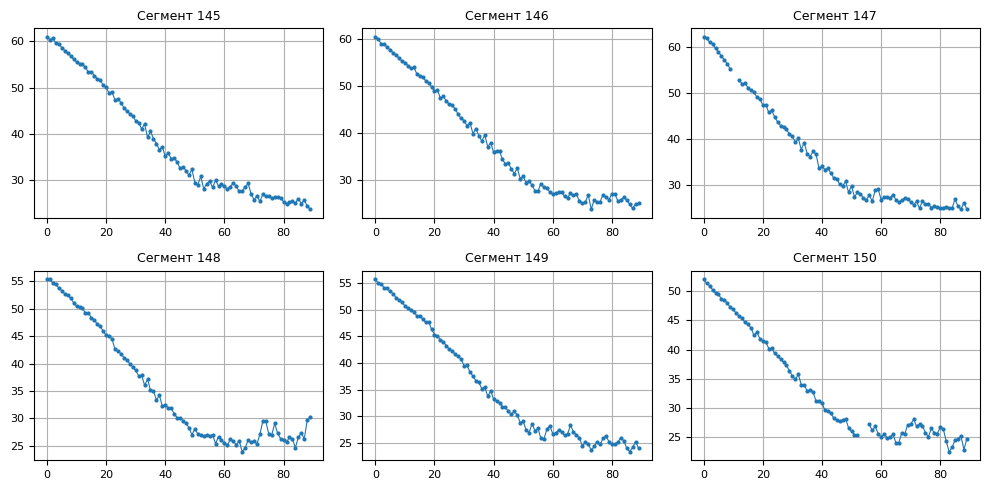

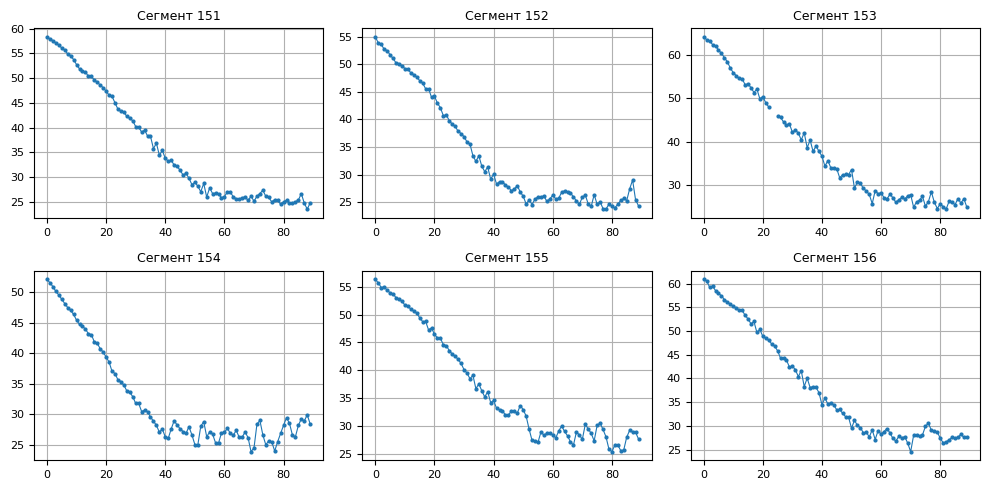

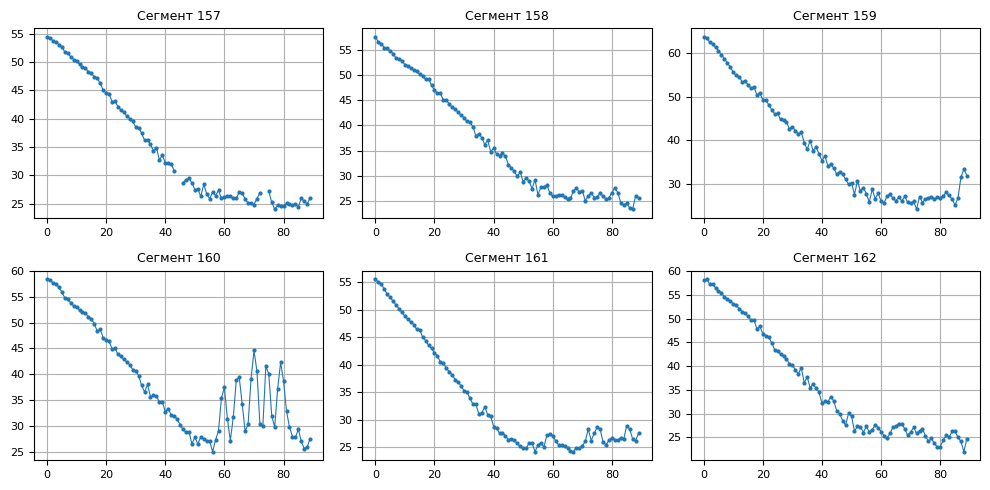

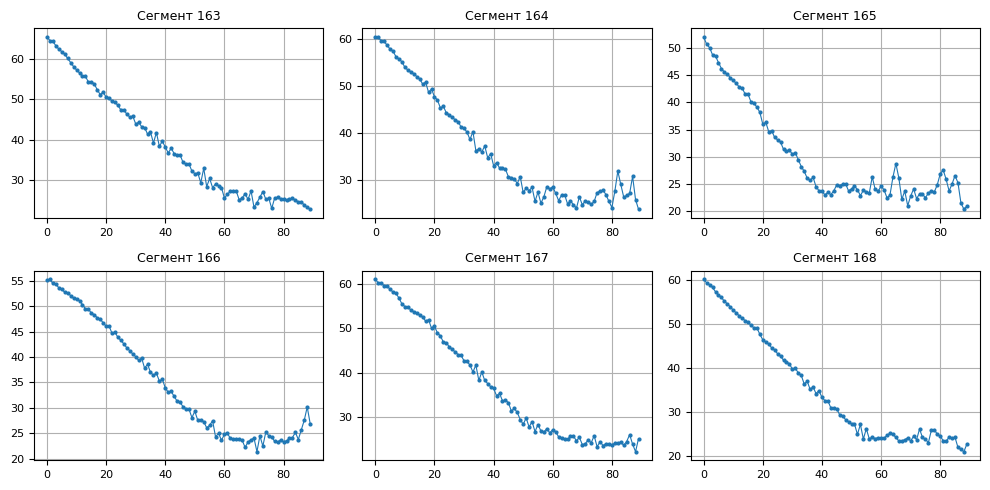

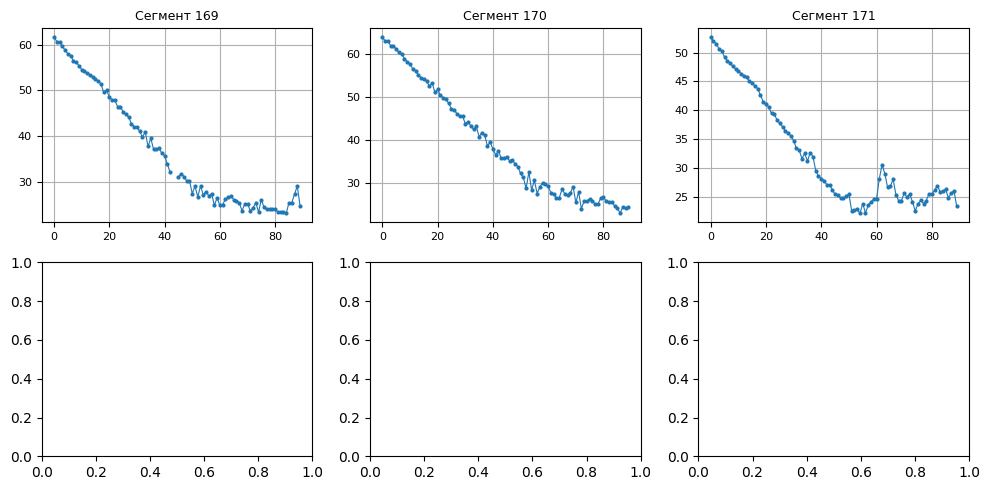

In [52]:
draw_wave_list(note_graph)

## Навчання моделі 

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(note_graph, note_code, test_size=0.2, stratify=note_code)

In [58]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

RandomForestClassifier()

## Результат навчання

дуже непоганий

In [59]:
Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))

Accuracy: 0.9714285714285714


## Куточок тестування моделі

In [62]:
One_predict = model.predict([note_graph[80]])
print(One_predict, note_code[80])

[3] 3
